### Automating DCF Valuations using Python

In [1]:
#Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#defining initial parameters
g = 0.1
margin_ebidta = 0.1
depreciation_percent = 0.02
working_capital_percent = 0.1
tax_r = 0.20

cost_of_capital = 0.1
terminal_growth_rate = 0.05

#number of years to include in the DCF
n_years = 5

In [3]:
#Projecting company's X quartely sales for the next two years
year_list = ['2020_actual', '2021_budget', '2022_projected', '2023_projected', '2024_projected']
sales = pd.Series(index = year_list)
sales['2020_actual'] = 10
print(sales)

2020_actual       10.0
2021_budget        NaN
2022_projected     NaN
2023_projected     NaN
2024_projected     NaN
dtype: float64


<ipython-input-3-20c79ff65d5a>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sales = pd.Series(index = year_list)


In [4]:
# Assume company X has g% growth rate
growth_r = g
for year_list in range(1,5):
    sales[year_list] =  sales[year_list - 1] * (1 + growth_r)
print(sales)

2020_actual       10.000
2021_budget       11.000
2022_projected    12.100
2023_projected    13.310
2024_projected    14.641
dtype: float64


In [5]:
#computing the Free Cash Flow (FCF)
ebitda = sales * margin_ebidta
depreciation = sales * depreciation_percent
ebit = ebitda - depreciation
working_capital = sales * working_capital_percent
change_in_working_capital = working_capital.shift(1) - working_capital 
capex_percent = depreciation_percent
capex = -(sales * capex_percent)
tax_pay = -ebit * tax_r
tax_pay = tax_pay.apply(lambda x: min(x, 0))
fcf = ebit + depreciation + tax_pay + capex + change_in_working_capital

fcf

2020_actual            NaN
2021_budget       0.604000
2022_projected    0.664400
2023_projected    0.730840
2024_projected    0.803924
dtype: float64

In [6]:
#computing terminal value and discount factor
terminal_value = ((fcf[-1] * (1 + terminal_growth_rate)) / cost_of_capital - terminal_growth_rate)
discount_factor = [(1 / (1 + cost_of_capital)) ** i for i in range (1, n_years)]

In [7]:
#computing our final dcf 
dcf = (sum(fcf[1:] * discount_factor) + terminal_value * discount_factor[-1])
df_output = pd.DataFrame([sales, ebit, fcf], index = ['Sales', 'EBIT', 'FCF']).round(1)
df_output

,2020_actual,2021_budget,2022_projected,2023_projected,2024_projected
Sales,10.0,11.0,12.1,13.3,14.6
EBIT,0.8,0.9,1.0,1.1,1.2
FCF,NaN,0.6,0.7,0.7,0.8


In [8]:
#Simulating using Monte-Carlo
"""
Generating random samples obtaining a large amount of input variables and visualising with a normal distribution
"""
n_iter = 1000
def monte_carlo_simulation():
    #Probability distributions
    sales_growth_distribution = np.random.normal(loc=0.1, scale=0.01, size=n_iter)
    ebidta_margin_distribution = np.random.normal(loc=0.14, scale=0.02, size=n_iter)
    working_capital_percent_distributions = np.random.normal(loc=0.24, scale=0.01, size=n_iter)
    
    #Building a DCF for each of the simulations
    output_distribution = []
    for i in range(n_iter):
        for year in range(1, n_years):
            sales[year] = sales[year - 1] * (1 + sales_growth_distribution[0])
            ebidta = sales * ebidta_margin_distribution[i]
            depreciation = (sales * depreciation_percent)
            ebit = ebitda - depreciation
            working_capital = sales * working_capital_percent_distributions[i]
            change_in_working_capital = working_capital.shift(1) - working_capital 
            capex = -(sales * capex_percent)
            tax_pay = -ebit * tax_r
            tax_pay = tax_pay.apply(lambda x: min(x, 0))
            fcf = ebit + depreciation + tax_pay + capex + change_in_working_capital
            
            #Building the DCF Valuation
            terminal_value = (fcf[-1] * 1 + terminal_growth_rate) / (cost_of_capital - terminal_growth_rate)
            fcf[-1] += terminal_value
            discount_factor = [(1 / (1 + cost_of_capital)) ** i for i in range (1, n_years)]
            dcf_value = sum(fcf[1:] * discount_factor)
            
            output_distribution.append(dcf_value)
    return output_distribution

In [9]:
def plot(x):
    output_distribution = x
    x = output_distribution
    plt.hist(x, bins = 50)
    plt.xlabel('dcf value')
    plt.ylabel('count')
    plt.title('DCF Modelling using a Normal Distribution')
    plt.show()

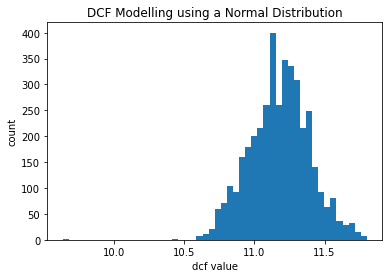

In [12]:
def main():
    x = monte_carlo_simulation()
    plot(x)
main()